## Notebook purpose/ criteria/ background info:

### Background
- A euclidean model has been used to calculate distance from samples to the ore body, and that distance has been used to classify provided samples as proximal or distal

### Aim
Can we use the same geochemical data and labels to generate a predictive model for future drill holes which can label samples on whether they are in class A or class B?

More data has been acquired since the geochemist completed her work - can we predict labels onto these data points (labelled “?”).

### Data
- 4472 unique geochemical assay samples

- Drill hole metadata included (uniqueID, holeid, from, to)
    - each sample derived from rock extracted from the ground which has been assayed to determine its chemical breakdown. 
    - Some not-required but additional information: ALS

- 8 assay elements - As, Au, Zn, Fe, S, Cu, Mo and Pb
- One class column with two labels - A, B. Approximately 800 samples have no labels and use ?.

### Output/ result:
- This notebook should show the workflow used, QAQC, results and observations

Steps in the notebook:
- Data loading and exploration
- data cleaning
- statistics
- model investigation
- visualisation

In [1]:
# is not using the dev container, packages can be installed within the notebook here.

#%pip install ydata-profiling -q

If using lupyter magic commands to install packages, use this list:
- pandas
- numpy
- matplotlib
- scikit-learn
- statsmodels

import required packages

In [2]:
import logging
import pandas as pd
import numpy as np

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

## Data reading, first pass check, cleaning/preparation
Import the data and investigate what state it's in

In [3]:
# data import

csv_path = '/workspaces/coding-test/data/data_for_distribution.csv'

df_original = pd.read_csv(csv_path)

In [4]:
display(df_original.head())

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class
0,A04812,SOLVE003,561,571.0,NaN,0.066,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,A
1,A03356,SOLVE003,571,581.0,NaN,0.152,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,A
2,A04764,SOLVE003,581,591.0,NaN,0.068,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,A
3,A04626,SOLVE003,591,601.0,NaN,0.074,891.60,48620.0,63.0000,4.200,820.8000,39.6000,A
4,A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,A


find out what the dypt of the columns are, how many not-null values er column etc.

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  4771 non-null   object 
 1   holeid     4771 non-null   object 
 2   from       4771 non-null   int64  
 3   to         4771 non-null   float64
 4   As         3268 non-null   float64
 5   Au         4765 non-null   object 
 6   Pb         4756 non-null   float64
 7   Fe         4709 non-null   float64
 8   Mo         4741 non-null   float64
 9   Cu         4746 non-null   float64
 10  S          4761 non-null   float64
 11  Zn         4762 non-null   float64
 12  Class      4771 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 484.7+ KB


Data cleaning/ prep and invesitgation of outliers

In [6]:
# need to convert some columns to different dtypes. Leaving 'class' as is for now.

df_clean = df_original.copy()

df_clean['from'] = df_clean['from'].astype('float32') # force from int to float
df_clean['Au'] = pd.to_numeric(df_clean['Au'], errors='coerce')

print(df_clean.dtypes)
print(df_clean.head())

Unique_ID     object
holeid        object
from         float32
to           float64
As           float64
Au           float64
Pb           float64
Fe           float64
Mo           float64
Cu           float64
S            float64
Zn           float64
Class         object
dtype: object
  Unique_ID    holeid   from     to  As        Au       Pb       Fe        Mo  \
0    A04812  SOLVE003  561.0  571.0 NaN  0.066000  1031.00  61380.0  138.2000   
1    A03356  SOLVE003  571.0  581.0 NaN  0.152000  1982.00  50860.0   75.4000   
2    A04764  SOLVE003  581.0  591.0 NaN  0.068000  1064.80  57940.0   29.2000   
3    A04626  SOLVE003  591.0  601.0 NaN  0.074000   891.60  48620.0   63.0000   
4    A05579  SOLVE003  601.0  611.0 NaN  0.043125   801.25  51025.0   56.0625   

      Cu          S       Zn Class  
0  3.600  3586.0000  43.6000     A  
1  4.800  1822.0000  36.4000     A  
2  3.000   740.4000  36.6000     A  
3  4.200   820.8000  39.6000     A  
4  4.875   745.6875  32.3125     A  


Check nodata/missing values per column

In [7]:
missing_values = df_clean.isnull().sum()
print(missing_values)

Unique_ID       0
holeid          0
from            0
to              0
As           1503
Au            470
Pb             15
Fe             62
Mo             30
Cu             25
S              10
Zn              9
Class           0
dtype: int64


Remove Nan values, fix negative numerical values for molybdenite column, map class values to numeric values

In [8]:
# create numeric representation of the class column for later on
# replace -999 values in Mo column with 0.00

# set A=0 and B=1 for sklearn later on, as these are the "known" training classes.
class_label_map = {'?':2, 
                    'A':0,
                    'B':1}

df_clean['class_num'] = df_clean['Class'].map(class_label_map)


df_clean.replace(-999, 0.00, inplace=True)
df_clean.replace(np.nan, 0.00, inplace=True)

df_clean.head()

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class,class_num
0,A04812,SOLVE003,561.0,571.0,0.0,0.066000,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,A,0
1,A03356,SOLVE003,571.0,581.0,0.0,0.152000,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,A,0
2,A04764,SOLVE003,581.0,591.0,0.0,0.068000,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,A,0
3,A04626,SOLVE003,591.0,601.0,0.0,0.074000,891.60,48620.0,63.0000,4.200,820.8000,39.6000,A,0
4,A05579,SOLVE003,601.0,611.0,0.0,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,A,0


confirm missing data issues have now been resolved:

In [9]:
missing_values = df_clean.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 Unique_ID    0
holeid       0
from         0
to           0
As           0
Au           0
Pb           0
Fe           0
Mo           0
Cu           0
S            0
Zn           0
Class        0
class_num    0
dtype: int64


## exploratory data analysis

Get some basic statistics for the element analysis columns

In [10]:
# List of element columns
element_columns = ['As', 'Au', 'Zn', 'Fe', 'S', 'Cu', 'Mo', 'Pb']

# Display descriptive statistics for element columns
df_clean[element_columns].describe()

,As,Au,Zn,Fe,S,Cu,Mo,Pb
count,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000
mean,13.515077,0.051647,59.277604,49303.372719,9729.597176,12.385360,15.791547,687.662406
std,32.107370,0.089961,120.403341,22087.433667,15547.737938,107.160726,39.115520,1046.706858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.010000,29.800000,38830.000000,1320.000000,3.000000,1.400000,131.100000
50%,5.600000,0.027000,38.200000,48760.000000,3620.000000,4.600000,4.400000,393.800000
75%,13.400000,0.061000,52.600000,58240.000000,10968.000000,8.000000,17.200000,937.700000
max,827.800000,1.878000,3455.000000,397000.000000,217600.000000,6767.000000,1939.400000,29793.800000


check the size of the classes (originally A, B and ? now 0, 1 and 2)

Class A, distal, is 2-3x the size of class B, proximal. Makes sense but will need to be balanced/ weighted in the model.

In [11]:
# Check the distribution of classes
class_counts = df_clean['class_num'].value_counts()
print(class_counts)


class_num
0    2861
1    1143
2     767
Name: count, dtype: int64


Check distribution of element data. 

(It's skewed, which is expected - we will get a smaller number of samples with high values near the ore body.)

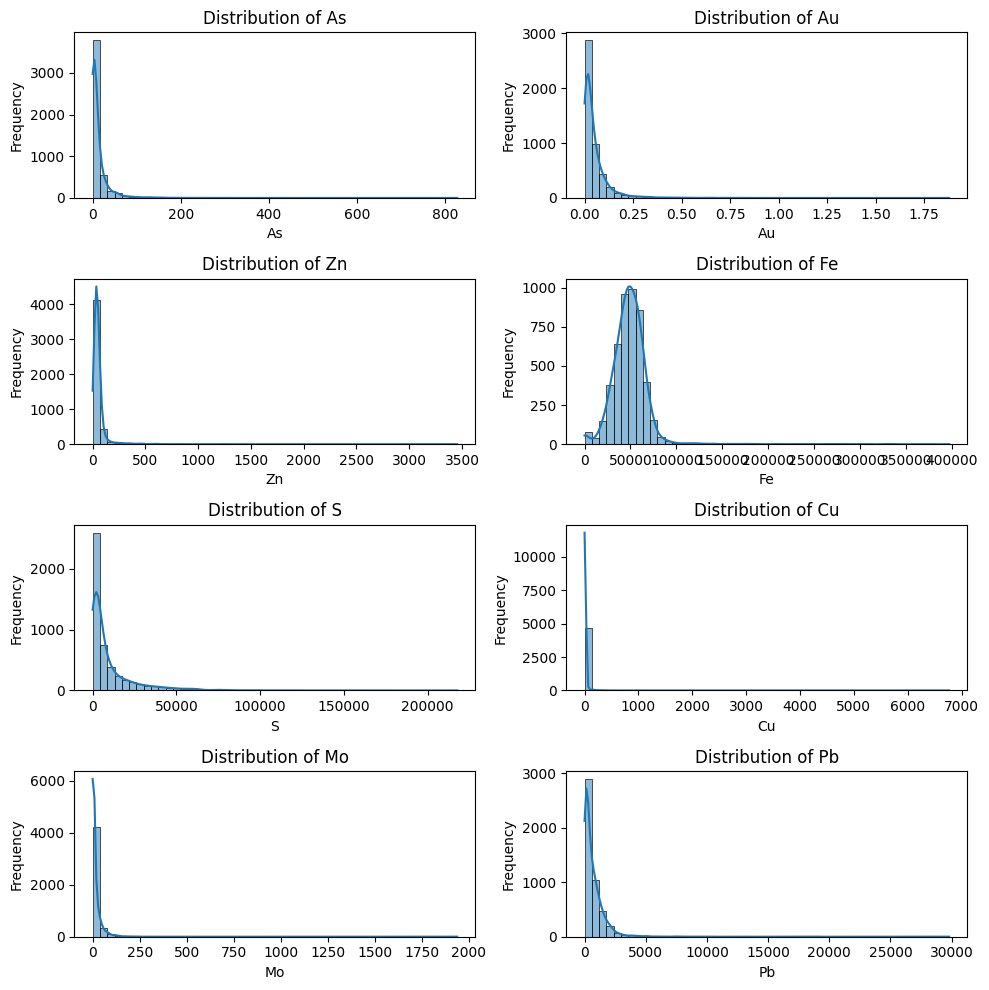

In [12]:
plt.figure(figsize=(10, 10))

for i, col in enumerate(element_columns):
    plt.subplot(4, 2, i+1)
    sns.histplot(df_clean[col], bins=50, kde=True) # COME BACK TO THIS
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Check for correlation between the element columns. 

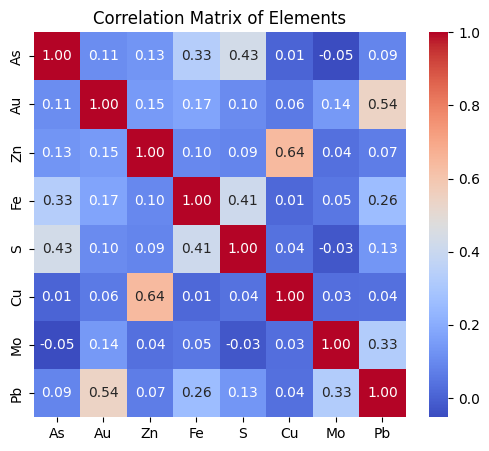

In [25]:
# Compute the correlation matrix
corr_matrix = df_clean[element_columns].corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Elements')
plt.show()

Higher correlation between some elements noted for later steps.

Data is skewed (expected, since most values not near the ore body will be low, and thoe near it will be high). Next step is applying a transformation to "normalise" the data ebfore trying to build a model.

I'm currently excluding the depth information, as it will probably introduce auto-correlation. It should be factored in later on in a model improvement.

### Data transformation

documentation for PowerTransformer [here](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PowerTransformer.html)

Note that if standardize is set to True, zero-mean unit variance normalisation is applied.

setting standardisation to True reduced the VIF scores below from 5-20 to less than 3, so it was left as True.

In [14]:
# log transform won't handle 0 values, so either a log(x + 1) or another method needs to be used.
# Yeo-Johnson transformation can handle 0 values. 
# # FULL DISCLOSURE, I haven't used this transformer before, and have not looked up in detail. It is intended for skewed data that contains zeros or negative values. THis dataset shouldn't contain negative values now that the Molybdenite values have been addressed. 
# PowerTransformer also accepts 'box-cox' as an input.

#make copy of 'cleaned' dataset before proceeding
df_transform = df_clean.copy()

pt = PowerTransformer(method='yeo-johnson', standardize=True) #set to true to put all data in a common scale. If set to false stdev for Fe is 236 but Au is 0.025, so scale is an issue.
df_transform[element_columns] = pt.fit_transform(df_transform[element_columns])

df_transform[element_columns].describe()

,As,Au,Zn,Fe,S,Cu,Mo,Pb
count,4.771000e+03,4.771000e+03,4.771000e+03,4.771000e+03,4.771000e+03,4.771000e+03,4.771000e+03,4.771000e+03
mean,4.765745e-17,-7.148617e-17,5.480606e-16,-6.076324e-16,2.144585e-16,-3.455165e-16,-2.382872e-17,-9.531489e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-1.271625e+00,-1.369124e+00,-9.087542e+00,-3.976901e+00,-3.818927e+00,-4.123630e+00,-2.219144e+00,-2.697218e+00
25%,-1.271625e+00,-8.650190e-01,-5.249973e-01,-4.433205e-01,-6.824962e-01,-5.898790e-01,-9.961741e-01,-7.090478e-01
50%,1.770510e-01,-1.747268e-01,-1.078381e-01,6.259325e-02,-5.883988e-02,-2.326641e-02,-1.121182e-01,3.602931e-02
75%,7.204663e-01,7.548388e-01,4.055401e-01,5.069970e-01,6.945241e-01,6.397190e-01,8.746145e-01,7.403886e-01
max,3.098296e+00,2.185648e+00,4.982681e+00,9.859121e+00,3.138309e+00,3.214680e+00,2.592211e+00,4.975582e+00


In [15]:
df_transform.head()

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class,class_num
0,A04812,SOLVE003,561.0,571.0,-1.271625,0.854580,0.824417,0.647464,1.909872,-0.343772,-0.064938,0.107645,A,0
1,A03356,SOLVE003,571.0,581.0,-1.271625,1.781701,1.444795,0.163916,1.665887,0.030906,-0.489346,-0.187650,A,0
2,A04764,SOLVE003,581.0,591.0,-1.271625,0.892379,0.853328,0.493415,1.192655,-0.589879,-1.015276,-0.178558,A,0
3,A04626,SOLVE003,591.0,601.0,-1.271625,0.999075,0.696320,0.055775,1.585256,-0.140602,-0.957207,-0.048721,A,0
4,A05579,SOLVE003,601.0,611.0,-1.271625,0.327874,0.604257,0.171803,1.530735,0.050521,-1.011285,-0.387240,A,0


Notes on yeo-josnson: standardize=False retains the original scale, which may be preferable depending on the modeling technique

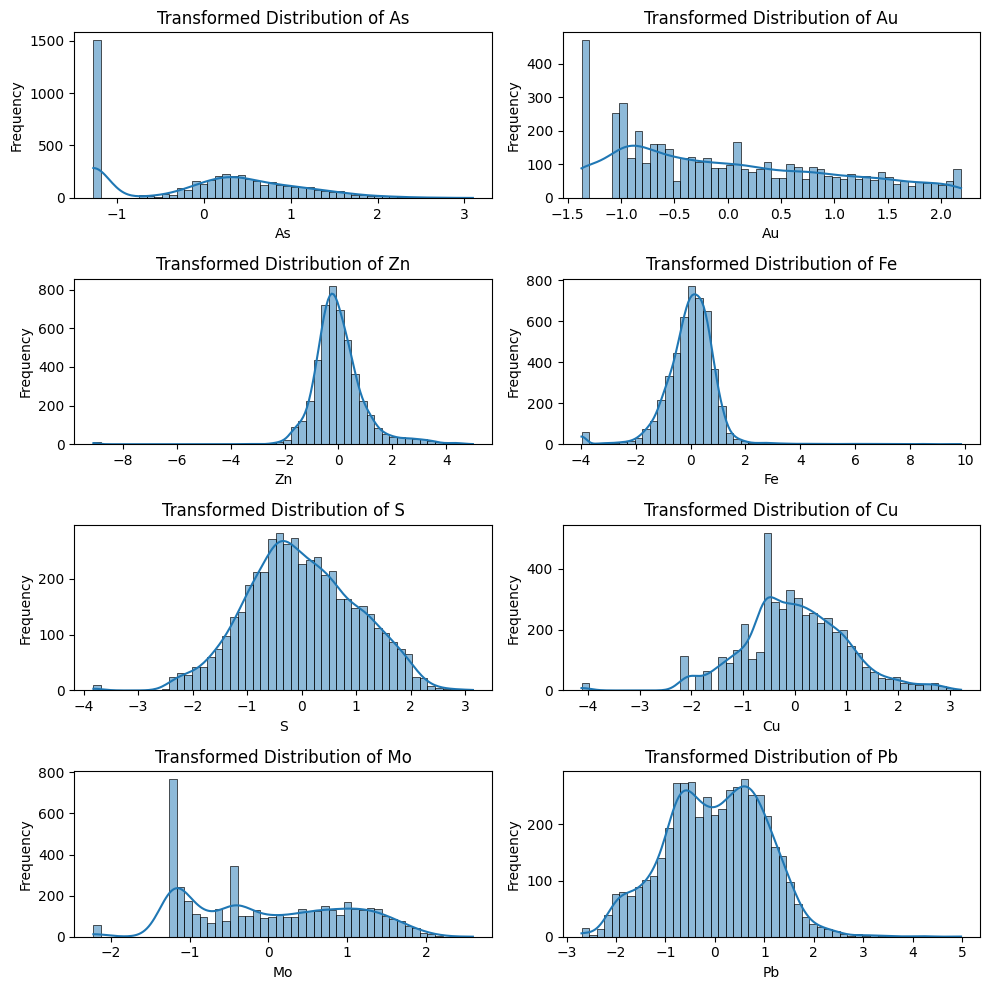

In [16]:
plt.figure(figsize=(10, 10))

for i, col in enumerate(element_columns):
    plt.subplot(4, 2, i+1)
    sns.histplot(df_transform[col], bins=50, kde=True)
    plt.title(f'Transformed Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
# Create a DataFrame with only the element columns
X = df_transform[element_columns]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF values above 10 indicate very high colinearity and if present should be factored in when choosing a model.")
print(vif_data)

VIF values above 10 indicate very high colinearity and if present should be factored in when choosing a model.
  Feature       VIF
0      As  1.232883
1      Au  1.654847
2      Zn  1.373215
3      Fe  1.188690
4       S  1.245378
5      Cu  1.428547
6      Mo  1.977281
7      Pb  2.517900


High VIF values indicate high colinearity. The correlation between some of the variables was shown in the confusion matrix above (especially between copper and zinc), however using the `PowerTransformer` and standarising the data has helped to reduce the VIFs.

- Previous runs of the notebook, with `standardise=False` had VIF values between 5-20. VIFs are now <3.


A tree-based model like random forest is also better able to handle colinearity than a linear model. So, let's try using a random forrest classifier (RF is popular in the remote sensing community, that's the only reason I've chosen it here. Other tree-based classifiers could be a better choice.)

## Splitting data and model training

In [18]:
# Question mark data was collected at a later date (aka data now labelled 0). So, we can use the data labelled as classes 1 and 2 as our 'ground truth' and attempt to classify anything that currently has a 0.


df_labeled = df_transform[df_transform['class_num'] != 2] #becuase we set A=0 and B=1, and '?'=2. So 2 represents our 'unlabelled results.
df_unlabeled = df_transform[df_transform['class_num'] == 2]

# Features and target variable
X = df_labeled[element_columns]
y = df_labeled['class_num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# class proportions
# if class sizes are imbalanced, need to resample so they are roghly on par.
class_proportions = y_train.value_counts(normalize=True)

# Check the shapes
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train distribution:\n{y_train.value_counts()}')
print(f'y_test distribution:\n{y_test.value_counts()}')
print('\nClass proportions in training data:')
print(class_proportions)


X_train shape: (2802, 8)
X_test shape: (1202, 8)
y_train distribution:
class_num
0    2002
1     800
Name: count, dtype: int64
y_test distribution:
class_num
0    859
1    343
Name: count, dtype: int64

Class proportions in training data:
class_num
0    0.71449
1    0.28551
Name: proportion, dtype: float64


In [19]:
# classes are skewed, apply class weights to counter this (decided to do this instead of sub-sample or generate data for the smaller class)

class_weights = {0: 1.0, 1: 2.5}

Using pipeline - this is meant to let me chain together multiple processing steps. I'm not sure familiar with sklearn's pipeline modeule, though I'm familiar with the concept in general and using python design patterns to make pipelines.

In [20]:
# I've left this here to 'show my working' but this was an earlier attempt, before swapping to the random forest classifier.

# pipeline = Pipeline([
#     ('scaler', StandardScaler()), #apparently optional for RF
#     ('logreg', LogisticRegression(penalty='l2', # L2 =  ridge regression. L1 = Lasso regression.
#                                 C=1.0, 
#                                 solver='liblinear',
#                                 class_weight=class_weights,
#                                 random_state=42)) # its the answer to the ultimate question in the universe!
# ])

In [21]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(
        class_weight=class_weights,
        random_state=42
    ))
])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       859
           1       0.86      0.68      0.76       343

    accuracy                           0.88      1202
   macro avg       0.87      0.82      0.84      1202
weighted avg       0.87      0.88      0.87      1202



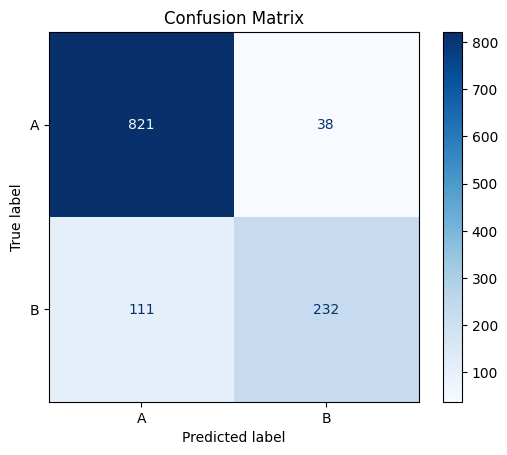

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B'])

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Confusion matrix shows that 425 samples correctly labelled as A and 183 correctly labelled as B. If class weights haven't been set correctly this would influence the higher accuracy of class A.

## Try to predict the newer, unlabelled samples

In [23]:
df_unlabeled = df_unlabeled.copy() #this stops the pandas warnings about not working on a copy.

# Prepare the unlabeled data
X_unlabeled = df_unlabeled[element_columns]

# Predict classes for the unlabeled data
unlabeled_predictions = pipeline.predict(X_unlabeled)

# Map predictions back to original class labels
df_unlabeled['predicted_class'] = unlabeled_predictions
df_unlabeled['predicted_class_label'] = df_unlabeled['predicted_class'].map({0: 'A', 1: 'B'})

# Preview the predictions
df_unlabeled[['Unique_ID', 'predicted_class_label']].head()

,Unique_ID,predicted_class_label
4004,A04920,A
4005,A05729,A
4006,A05270,A
4007,A05634,A
4008,A04689,A


## Summary
The objective of this jupyter notebook is to demonstrate if it is feasible to use the provided dataset to build a predicitve model that could classify future drill hole samples as being proximal (close to) or distal (far away) from an ore body. This notebook demonstrates one approach for doing this, using the metal abundances provided in the dataset and a random forest classifier from the python package `scikit-learn`. The classifier was trained using samples that had alreay been labelled as proximal or distal, and then applied to new samples that had not been classified. 

Below is a short summary of the steps that were applied, and areas for improvement.


- Data was imported, cleaned and prepared
    - ensuring all columns are the correct type
    - removing erroneous values (-999)
    - replace nan values with 0.00 as sklearn doesn't handle Nan values well

- Addressing data skewness and class imbalance
    - data was skewed, and so a transformation was applied to address this
    - standardisation was also applied to address scale between input variables (e.g. standard deviation for Fe was 200+, standard deviation for Au was 0.02)
    - class A and class B are different sizes (class A was 3x size of class B), so this was addressed by applying class weights

- Model selection
    - Random forest classifier - chosen because it is able to handle colinearity between the element columns
    - class weights applied to try and balance class A and class B
    - training/testing split of 70-30 used
    - confusion matrix used to provide some more information on the correct classification of classes A and B, and when not classified correctly, how they were mis-classified

## Results

- Recall:
- F1:


## Further work/ improvements

- Depth data was not included, but it should be explored (noting spatial auto correlation will need to be addressed)
- No grouping was done by borehole. It is also possible there will be auto correlation between bore holes based on their location. If lat/long data is also included, this can be explored in future.
- confusion matrix used to assess the mis-classification between class A and B, but additional accuracy metrics would help get a better understanding of the model and its accuracy.